# Semantic Segmentation

语义分割即是对图像中每一个像素点进行分类，确定每个点的类别（如属于背景、人或车等），从而进行区域划分

[Image Segmentation Techniques](../../doc/image%20segmentation.pdf)

<table><tbody><tr><td><strong>Techniques</strong></td><td> <strong>Description</strong></td><td> <strong>Advantages</strong></td><td><strong>Disadvantages</strong></td></tr><tr><td> Thresholding Method</td><td> Focuses on finding peak values based on the histogram of the image to find similar pixels</td><td> Doesn’t require complicated pre-processing, simple</td><td> Many details can get omitted, threshold errors are common</td></tr><tr><td> Edge Based Method</td><td> based on discontinuity detection unlike similarity detection</td><td> Good for images having better<br> contrast between objects.</td><td> Not suitable for noisy images</td></tr><tr><td> Region-Based Method</td><td> based on partitioning an image into homogeneous regions</td><td> Works really well for images with a considerate amount of noise, can take user markers for fasted evaluation</td><td> Time and memory consuming</td></tr><tr><td> Traditional Segmentation Algorithms</td><td> Divides image into k number of homogenous, mutually exclusive clusters – hence obtaining objects</td><td> Proven methods, reinforced with fuzzy logic and more useful for real-time application.</td><td> Determining cost function for minimization can be difficult.</td></tr><tr><td> Watershed Method</td><td> based on topological interpretation of image boundaries</td><td> segments obtained are more stable, detected boundaries are distinct</td><td> Gradient calculation for ridges is complex.</td></tr><tr><td> Neural Networks</td><td> based on deep learning algorithms – Convolutional Neural Networks</td><td> easy implementation, no need for following any complicated algorithms, ready-made libraries available in Python, more practical applications</td><td> Training the model for custom and business images is time consuming and resource costly.</td></tr></tbody></table>




# U-Net for semantic segmentation


    In semantic segmentation, each pixel is assigned to an object category;
    In instance segmentation, each pixel is assigned to an individual object;
    The U-Net architecture can be used for semantic segmentation;
    The Mask R-CNN architecture can be used for instance segmentation.

## FCN/U-Net网络解析

https://zhuanlan.zhihu.com/p/31428783


由于常规的DNN使用了Convolution和pooling，使得后面的输出维度降低。FCN/U-Net使用了Deconvolution进行upsampling

算法步骤：

    下采样+上采样：Convlution + Deconvlution／Resize
    多尺度特征融合：特征逐点相加／特征channel维度拼接获得像素级别的segement map：
    对每一个像素点进行判断类别
    
多尺度融合上，FCN采用逐点相加，对应caffe的EltwiseLayer层，对应tensorflow的tf.add()；U-Net采用channel维度拼接融合，对应caffe的ConcatLayer层，对应tensorflow的tf.concat()

U-Net Uses Weighted Cross-Entropy Loss

The weight map w is pre-computed based off of each ground truth segmentation using traditional computer vision techniques. Specifically, morphological image processing is applied to the ground truth segmentation to identify the thin borders that separate cells, and then the weight map is created so that these thin borders separating cells are given high weights. Incorporating this weight map into the cross-entropy loss means that the U-Net will be heavily penalized if it leaves out these thin borders between cells or if it draws them in the wrong place. The overall goal of using the weight map in the loss is to “force the network to learn the small separation borders between touching cells.”

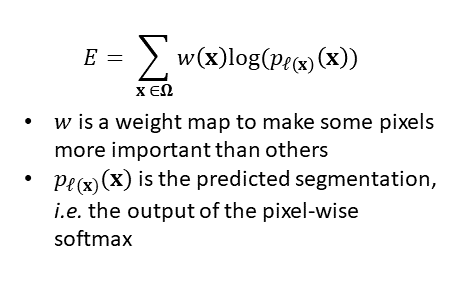

Mask R-CNN for Instance Segmentation

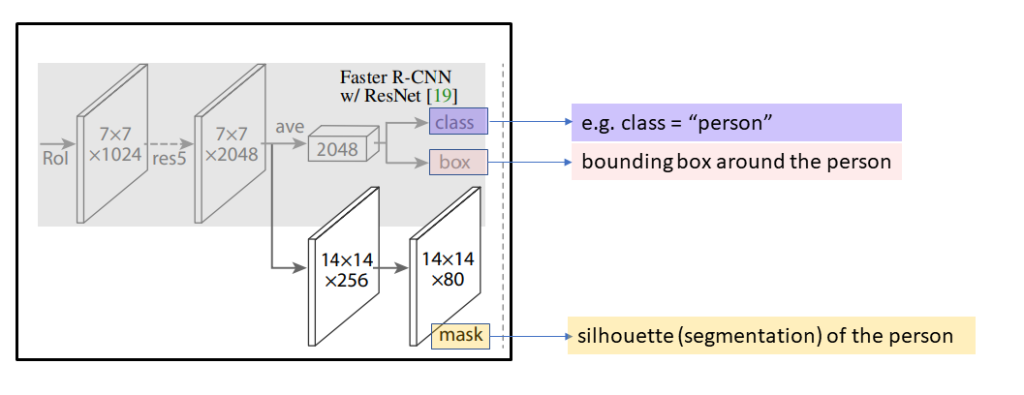

https://glassboxmedicine.com/2020/01/21/segmentation-u-net-mask-r-cnn-and-medical-applications/

# Retina blood vessel segmentation with a convolution neural network (U-net)

https://github.com/orobix/retina-unet

Before training, the 20 images of the DRIVE training datasets are pre-processed with the following transformations:

    Gray-scale conversion
    Standardization
    Contrast-limited adaptive histogram equalization (CLAHE)
    Gamma adjustment


https://www.cnblogs.com/RyanXing/p/CLAHE.html

#### histogram equalization 

经典的histogram equalization实际上是对原灰度直方图的拉伸 

#### adaptive histogram equalization
AHE的思想很简单："Since our eyes adapt to the local context of images to evaluate their contents, it makes sense to optimize local image contrast (Pizer et al. 1987)."

大体上是：为了改善局部对比度，我们采用块操作。此时HE在每一个块上都会最优，从而实现各个局部最优。进一步，为了避免边界效应，我们组合块时采用双线性插值法，而不是简单的合并。

#### CLAHE

CLAHE在局部直方图均衡化（又称自适应直方图均衡化AHE）的基础上，对每个子块直方图做了限制，很好的控制了AHE带来的噪声。CLAHE与AHE的不同主要在于其对于对比度的限幅，在CLAHE中，对于每个小区域都必须使用对比度. 

限制变换函数的cumulative distribution function的斜率。大斜率导致低灰度值映射到高灰度值，使原本集中的黑色背景“点亮”。这就是CLAHE的根本思想

Karel Zuiderveld, "Contrast Limited Adaptive Histogram Equalization", Graphics Gems IV, p. 474-485, code: p. 479-484

The training of the neural network is performed on sub-images (patches) of the pre-processed full images. Each patch, of dimension 48x48, is obtained by randomly selecting its center inside the full image. Also the patches partially or completely outside the Field Of View (FOV) are selected, in this way the neural network learns how to discriminate the FOV border from blood vessels.

# Data

In [1]:
# %load prepare_datasets_DRIVE.py
#==========================================================
#
#  This prepare the hdf5 datasets of the DRIVE database
#
#============================================================

import os
import h5py
import numpy as np
from PIL import Image



def write_hdf5(arr,outfile):
    with h5py.File(outfile,"w") as f:
        f.create_dataset("image", data=arr, dtype=arr.dtype)


#------------Path of the images --------------------------------------------------------------
#train
original_imgs_train = "../../data/fundus/DRIVE/train_data/"
groundTruth_imgs_train = "../../data/fundus/DRIVE/train_label/"
borderMasks_imgs_train = "../../data/fundus/DRIVE/train_mask/"
#test
original_imgs_test = "../../data/fundus/DRIVE/test_data/"
groundTruth_imgs_test = "../../data/fundus/DRIVE/test_label/"
borderMasks_imgs_test = "../../data/fundus/DRIVE/test_mask/"
#---------------------------------------------------------------------------------------------

Nimgs = 20
channels = 3
height = 584
width = 565
dataset_path = "./h5_dataset/"

def get_datasets(imgs_dir,groundTruth_dir,borderMasks_dir,train_test="null"):
    imgs = np.empty((Nimgs,height,width,channels))
    groundTruth = np.empty((Nimgs,height,width))
    border_masks = np.empty((Nimgs,height,width))
    for path, subdirs, files in os.walk(imgs_dir): #list all files, directories in the path
        for i in range(len(files)):
            # print(files[i])
            #original
            print("original image: " +files[i])
            img = Image.open(imgs_dir+files[i])
            imgs[i] = np.asarray(img)
            #corresponding ground truth
            groundTruth_name = files[i][0:2] + "_manual1.gif"
            print("ground truth name: " + groundTruth_name)
            g_truth = Image.open(groundTruth_dir + groundTruth_name)
            groundTruth[i] = np.asarray(g_truth)
            #corresponding border masks
            border_masks_name = ""
            if train_test=="train":
                border_masks_name = files[i][0:2] + "_training_mask.gif"
            elif train_test=="test":
                border_masks_name = files[i][0:2] + "_test_mask.gif"
            else:
                print("specify if train or test!!")
                exit()
            print("border masks name: " + border_masks_name)
            b_mask = Image.open(borderMasks_dir + border_masks_name)
            border_masks[i] = np.asarray(b_mask)

    print("imgs max: " +str(np.max(imgs)))
    print("imgs min: " +str(np.min(imgs)))
    assert(np.max(groundTruth)==255 and np.max(border_masks)==255)
    assert(np.min(groundTruth)==0 and np.min(border_masks)==0)
    print("ground truth and border masks are correctly withih pixel value range 0-255 (black-white)")
    #reshaping for my standard tensors
    imgs = np.transpose(imgs,(0,3,1,2))
    assert(imgs.shape == (Nimgs,channels,height,width))
    groundTruth = np.reshape(groundTruth,(Nimgs,1,height,width))
    border_masks = np.reshape(border_masks,(Nimgs,1,height,width))
    assert(groundTruth.shape == (Nimgs,1,height,width))
    assert(border_masks.shape == (Nimgs,1,height,width))
    return imgs, groundTruth, border_masks

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
#getting the training datasets
imgs_train, groundTruth_train, border_masks_train = get_datasets(original_imgs_train,groundTruth_imgs_train,borderMasks_imgs_train,"train")
print("saving train datasets")
write_hdf5(imgs_train, dataset_path + "DRIVE_dataset_imgs_train.hdf5")
write_hdf5(groundTruth_train, dataset_path + "DRIVE_dataset_groundTruth_train.hdf5")
write_hdf5(border_masks_train,dataset_path + "DRIVE_dataset_borderMasks_train.hdf5")

#getting the testing datasets
imgs_test, groundTruth_test, border_masks_test = get_datasets(original_imgs_test,groundTruth_imgs_test,borderMasks_imgs_test,"test")
print("saving test datasets")
write_hdf5(imgs_test,dataset_path + "DRIVE_dataset_imgs_test.hdf5")
write_hdf5(groundTruth_test, dataset_path + "DRIVE_dataset_groundTruth_test.hdf5")
write_hdf5(border_masks_test,dataset_path + "DRIVE_dataset_borderMasks_test.hdf5")

original image: 21_training.tif
ground truth name: 21_manual1.gif
border masks name: 21_training_mask.gif
original image: 22_training.tif
ground truth name: 22_manual1.gif
border masks name: 22_training_mask.gif
original image: 23_training.tif
ground truth name: 23_manual1.gif
border masks name: 23_training_mask.gif
original image: 24_training.tif
ground truth name: 24_manual1.gif
border masks name: 24_training_mask.gif
original image: 25_training.tif
ground truth name: 25_manual1.gif
border masks name: 25_training_mask.gif
original image: 26_training.tif
ground truth name: 26_manual1.gif
border masks name: 26_training_mask.gif
original image: 27_training.tif
ground truth name: 27_manual1.gif
border masks name: 27_training_mask.gif
original image: 28_training.tif
ground truth name: 28_manual1.gif
border masks name: 28_training_mask.gif
original image: 29_training.tif
ground truth name: 29_manual1.gif
border masks name: 29_training_mask.gif
original image: 30_training.tif
ground truth n

# Train

modify 'configuration.txt' to set correct data paths and output dir.  

```
[data paths]
path_local =  ./h5_dataset/
train_imgs_original = DRIVE_dataset_imgs_train.hdf5
train_groundTruth = DRIVE_dataset_groundTruth_train.hdf5
train_border_masks = DRIVE_dataset_borderMasks_train.hdf5
test_imgs_original = DRIVE_dataset_imgs_test.hdf5
test_groundTruth = DRIVE_dataset_groundTruth_test.hdf5
test_border_masks = DRIVE_dataset_borderMasks_test.hdf5

[experiment name]
#model weights will be put inside this folder
name = result
```

`nohup` is a POSIX command which means "no hang up". Its purpose is to execute a command such that it ignores the HUP signal and therefore does not stop when the user logs out.

In [ ]:
# %load run_training.py
###################################################
#
#   Script to launch the training
#
##################################################

import os, sys
import configparser


#config file to read from
config = configparser.RawConfigParser()
config.readfp(open(r'./configuration.txt'))
#===========================================
#name of the experiment
name_experiment = config.get('experiment name', 'name')
nohup = config.getboolean('training settings', 'nohup')   #std output on log file?

run_GPU = '' if sys.platform == 'win32' else ' THEANO_FLAGS=device=gpu,floatX=float32 '

#create a folder for the results
result_dir = name_experiment
print ("\n1. Create directory for the results (if not already existing)" )
if os.path.exists(result_dir):
    print ("Dir already existing")
elif sys.platform=='win32':
    os.system('mkdir ' + result_dir)
else:
    os.system('mkdir -p ' +result_dir)

print ("copy the configuration file in the results folder")
if sys.platform=='win32':
    os.system('copy configuration.txt .\\' +name_experiment+'\\'+name_experiment+'_configuration.txt')
else:
    os.system('cp configuration.txt ./' +name_experiment+'/'+name_experiment+'_configuration.txt')

# run the experiment
if nohup:
    print ("\n2. Run the training on GPU with nohup")
    os.system(run_GPU +' nohup python -u ./src/retinaNN_training.py > ' +'./'+name_experiment+'/'+name_experiment+'_training.nohup')
else:
    print ("\n2. Run the training on GPU (no nohup)")
    os.system(run_GPU +' python ./src/retinaNN_training.py')

#Prediction/testing is run with a different script


C:\Users\eleve\AppData\Local\Temp\ipykernel_13688\2720979513.py:14: DeprecationWarning: This method will be removed in future versions.  Use 'parser.read_file()' instead.
  config.readfp(open(r'./configuration.txt'))



1. Create directory for the results (if not already existing)
copy the configuration file in the results folder

2. Run the training on GPU (no nohup)


* The training details are displayed inside the jupyter notebook console. 

# Test

In [ ]:
# %load run_testing.py
###################################################
#
#   Script to execute the prediction
#
##################################################

import os, sys
import configparser


#config file to read from
config = configparser.RawConfigParser()
config.read_file(open(r'./configuration.txt'))
#===========================================
#name of the experiment!!
name_experiment = config.get('experiment name', 'name')
nohup = config.getboolean('testing settings', 'nohup')   #std output on log file?

run_GPU = '' if sys.platform == 'win32' else ' THEANO_FLAGS=device=gpu,floatX=float32 '

#create a folder for the results if not existing already
result_dir = name_experiment
print ("\n1. Create directory for the results (if not already existing)")
if os.path.exists(result_dir):
    pass
elif sys.platform=='win32':
    os.system('md ' + result_dir)
else:
    os.system('mkdir -p ' + result_dir)


# finally run the prediction
if nohup:
    print ("\n2. Run the prediction on GPU  with nohup")
    os.system(run_GPU +' nohup python -u ./src/retinaNN_predict.py > ' +'./'+name_experiment+'/'+name_experiment+'_prediction.nohup')
else:
    print ("\n2. Run the prediction on GPU (no nohup)")
    os.system(run_GPU +' python ./src/retinaNN_predict.py')


## About Jaccard Similarity

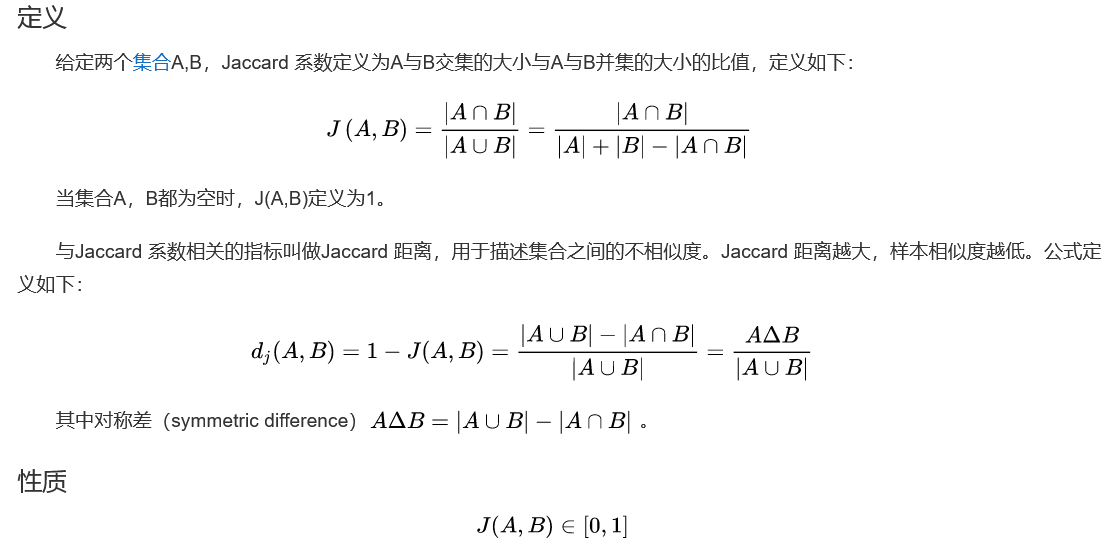

https://baike.baidu.com/item/Jaccard%E7%B3%BB%E6%95%B0/6784913